In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, make_scorer
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('error')


In [24]:
filepath = os.path.join(os.getcwd(), '../data/final_experiment.csv')
df = pd.read_csv(filepath)
df['Class'] = df['Class'].apply(lambda val: 0 if val == 'Benign' else 1)
df = shuffle(df, random_state = 2)

In [25]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
random_state=1, stratify=y)

In [26]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (22078, 34)
X_test shape (14719, 34)
y_train shape (22078,)
y_test shape (14719,)


In [27]:
# Checking the range of parameters

max_depth = [3,4,5,6,7,8]
max_leaf_nodes= [4,6,8,10,12,14,16,18]
min_samples_split =  np.arange(30,200,30)
train_accuracy = []
test_accuracy = []

for par in min_samples_split:
    clf = DecisionTreeClassifier(criterion='gini', min_samples_split=par, random_state =1)
    #Fit the model
    clf.fit(X_train, y_train)
    #Compute accuracy on the training set and test set
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
  

In [28]:
train_loss = []
validation_loss = []

for score in train_accuracy:
    train_loss.append((1 - score))

for score in test_accuracy:
    validation_loss.append((1 - score))

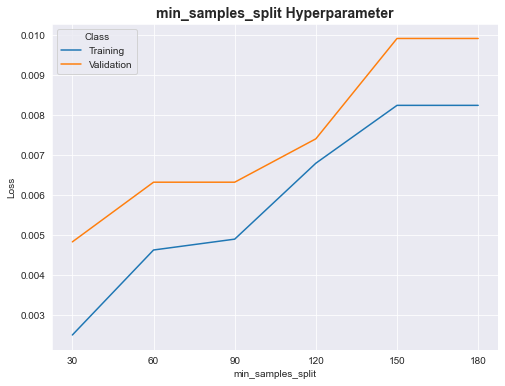

In [29]:
# # #Generate plot
x_ticks = np.arange(0, len(min_samples_split))
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6));
sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
ax.set_title('min_samples_split Hyperparameter', fontsize=14, fontweight='bold');
ax.set(xlabel='min_samples_split', ylabel='Loss');
ax.legend(title='Class', labels=['Training', 'Validation']);
plt.xticks(ticks=x_ticks, labels=min_samples_split);
# plt.savefig('../tuning/exp3_dt_min_samples_split.png', dpi=300)

In [30]:
# hyperparamer tuning
param_grid = {
    'criterion': ['gini'],
    'max_depth' : [4,5,6],
    'max_leaf_nodes': [8,10,12,14],
    'min_samples_split': [60,70,80,90],
    'max_features': ["sqrt"],     
    }
dt = DecisionTreeClassifier(random_state=99)
dtgrid = GridSearchCV(dt,param_grid,verbose =1,cv=5)
dtgrid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [8, 10, 12, 14],
                         'min_samples_split': [60, 70, 80, 90]},
             verbose=1)

In [31]:
print(f'Best estimator:  {dtgrid.best_estimator_}')
print(f'Best score: {(dtgrid.best_score_ * 100):.3f} %')

Best estimator:  DecisionTreeClassifier(max_depth=6, max_features='sqrt', max_leaf_nodes=14,
                       min_samples_split=90, random_state=99)
Best score: 98.274 %


In [32]:
dt = DecisionTreeClassifier(
            criterion="gini", 
             max_depth=dtgrid.best_params_["max_depth"],
             max_leaf_nodes=dtgrid.best_params_["max_leaf_nodes"],
             min_samples_split = dtgrid.best_params_['min_samples_split'],
             max_features="sqrt",
             random_state=1
        ) 

In [33]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 14,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 90,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [34]:
# evaluating the models

In [35]:
def sensitivity(conf):
 return conf[1][1] / (conf[1][1] + conf[1][0])

def specificity(conf):
 return conf[0][0] / (conf[0][0] + conf[0][1])


In [36]:
def evaluate_model(X, y):

    train_accuracy = []
    test_accuracy = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrix_scores = []
    precision_scores = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    for train, test in  cv.split(X,y):
        X_train_strat = X.iloc[train]
        y_train_strat = y.iloc[train]
        X_test_strat = X.iloc[test]
        y_test_strat = y.iloc[test]
        
        
        #Fit the model
        dt.fit(X_train_strat, y_train_strat)
        #Compute accuracy on the training set and test set
        
        y_pred_train_strat = dt.predict(X_train_strat)
        y_pred_strat = dt.predict(X_test_strat)
        
        
        train_accuracy.append(accuracy_score(y_train_strat, y_pred_train_strat))
        test_accuracy.append(accuracy_score(y_test_strat, y_pred_strat))
        
        
        conf = confusion_matrix(y_test_strat,y_pred_strat)

        confusion_matrix_scores.append(conf) 

        precision_scores.append(precision_score(y_test_strat,y_pred_strat))
        sensitivity_scores.append(sensitivity(conf))
        specificity_scores.append(specificity(conf))

    return (train_accuracy, test_accuracy, confusion_matrix_scores, 
            precision_scores,sensitivity_scores, 
            specificity_scores)



In [37]:
train_accuracy, test_accuracy, confusion_matrix_scores, precision_scores, sensitivity_scores,specificity_scores = evaluate_model(X, y)

In [38]:
def average(array):
    total = 0
    for score in array:
        total += score

    return (f'{(total / 5 * 100):.2f}')

def score(array):
    for score in array:
        print(f'{(score * 100):.2f}') 

In [39]:
score(train_accuracy)
average(train_accuracy)


96.96
96.72
96.74
96.79
96.98


'96.84'

In [40]:
score(test_accuracy)
average(test_accuracy)

97.17
96.64
96.56
96.74
96.86


'96.80'

In [41]:
for cf in confusion_matrix_scores:
    print(cf , "\n")

[[3897  108]
 [ 100 3255]] 

[[3953   52]
 [ 195 3160]] 

[[3949   56]
 [ 197 3157]] 

[[3924   80]
 [ 160 3195]] 

[[3923   81]
 [ 150 3205]] 



In [42]:
# precision_scores
score(precision_scores)
average(precision_scores)

96.79
98.38
98.26
97.56
97.53


'97.70'

In [43]:
# sensitivity_scores
score(sensitivity_scores)
average(sensitivity_scores)

97.02
94.19
94.13
95.23
95.53


'95.22'

In [44]:
# specificity_scores
score(specificity_scores)
average(specificity_scores)

97.30
98.70
98.60
98.00
97.98


'98.12'